In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Nissan.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_100 NX,Seri_200 SX,Seri_350 Z,...,Model_2.0 Turbo,Model_2.3i,Model_Coupe,Model_NX,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,479900,2009,80,1240,22000,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,485000,2017,80,1198,12000,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,315000,2000,100,1597,86000,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,285000,2006,80,1240,180000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,487000,2011,80,1198,22000,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_15392\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,92735.844574,1.951753e+09,44178.644111,32240.182228


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:18:36,132] A new study created in memory with name: no-name-03d4ae17-c1d9-4882-99a2-ea2f4d082410
[I 2023-10-08 14:18:36,238] Trial 0 finished with value: 329554.95340771176 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.009962879498538824, 'max_depth': 10, 'min_child_weight': 67}. Best is trial 0 with value: 329554.95340771176.
[I 2023-10-08 14:18:36,265] Trial 4 finished with value: 359114.71277272806 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.0013620968828181063, 'max_depth': 15, 'min_child_weight': 266}. Best is trial 0 with value: 329554.95340771176.
[I 2023-10-08 14:18:36,273] Trial 2 finished with value: 314380.66101117275 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.14629592550051096, 'max_depth': 13, 'min_child_weight': 121}. Best is trial 2 with value: 314380.66101117275.
[I 2023-10-08 14:18:36,273] Trial 1 finished with value: 363649.26697882084 and parameter

[I 2023-10-08 14:18:37,191] Trial 29 finished with value: 70246.18667477062 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.46564263295936453, 'max_depth': 13, 'min_child_weight': 63}. Best is trial 24 with value: 68611.81512703418.
[I 2023-10-08 14:18:37,203] Trial 31 finished with value: 70574.55615499603 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.4722748446071382, 'max_depth': 13, 'min_child_weight': 59}. Best is trial 24 with value: 68611.81512703418.
[I 2023-10-08 14:18:37,267] Trial 32 finished with value: 64762.87458655546 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.30733254411333866, 'max_depth': 13, 'min_child_weight': 64}. Best is trial 32 with value: 64762.87458655546.
[I 2023-10-08 14:18:37,296] Trial 33 finished with value: 62555.25487301541 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.45659084209690215, 'max_depth': 13, 'min_child_weight'

[I 2023-10-08 14:18:38,501] Trial 60 finished with value: 64315.89068161666 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.3110065342231336, 'max_depth': 13, 'min_child_weight': 52}. Best is trial 57 with value: 62168.00150039588.
[I 2023-10-08 14:18:38,607] Trial 63 finished with value: 81771.7488060113 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.30232643700158884, 'max_depth': 13, 'min_child_weight': 115}. Best is trial 57 with value: 62168.00150039588.
[I 2023-10-08 14:18:38,621] Trial 61 finished with value: 74160.81795459994 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.3230826790898011, 'max_depth': 13, 'min_child_weight': 108}. Best is trial 57 with value: 62168.00150039588.
[I 2023-10-08 14:18:38,626] Trial 62 finished with value: 78911.04052521607 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3138684864810949, 'max_depth': 13, 'min_child_weight':

[I 2023-10-08 14:18:39,922] Trial 90 finished with value: 73888.35550084886 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.35502704110328703, 'max_depth': 15, 'min_child_weight': 66}. Best is trial 76 with value: 58467.449369694754.
[I 2023-10-08 14:18:39,952] Trial 91 finished with value: 65305.28319317883 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3721521984035619, 'max_depth': 15, 'min_child_weight': 69}. Best is trial 76 with value: 58467.449369694754.
[I 2023-10-08 14:18:40,034] Trial 92 finished with value: 101912.77124385614 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.12568292153466626, 'max_depth': 15, 'min_child_weight': 67}. Best is trial 76 with value: 58467.449369694754.
[I 2023-10-08 14:18:40,133] Trial 93 finished with value: 131127.07772534626 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3691325053205334, 'max_depth': 15, 'min_child_wei

[I 2023-10-08 14:18:41,506] Trial 122 finished with value: 65847.50524334403 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.24320699578077334, 'max_depth': 8, 'min_child_weight': 7}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:41,506] Trial 121 finished with value: 66494.72985874722 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.22811798659545285, 'max_depth': 8, 'min_child_weight': 5}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:41,522] Trial 120 finished with value: 66003.24303443516 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.2564811045439548, 'max_depth': 8, 'min_child_weight': 5}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:41,546] Trial 123 finished with value: 65888.76374113068 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.26198288749211607, 'max_depth': 8, 'min_child_weight'

[I 2023-10-08 14:18:43,107] Trial 151 finished with value: 64611.34420741802 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4296382168290269, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:43,113] Trial 150 finished with value: 63259.86995811484 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.407252812438034, 'max_depth': 7, 'min_child_weight': 45}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:43,232] Trial 152 finished with value: 61409.01570198225 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.39814026350881165, 'max_depth': 7, 'min_child_weight': 38}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:43,283] Trial 153 finished with value: 61677.44911545199 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.40694423685260545, 'max_depth': 7, 'min_child_weight

[I 2023-10-08 14:18:44,807] Trial 180 finished with value: 63779.12575246996 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.32917920409148677, 'max_depth': 8, 'min_child_weight': 27}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:44,926] Trial 181 finished with value: 347870.8641800163 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.004367646409538322, 'max_depth': 8, 'min_child_weight': 20}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:44,926] Trial 182 finished with value: 68836.30293392978 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.3414159039199011, 'max_depth': 8, 'min_child_weight': 25}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:44,998] Trial 183 finished with value: 72374.01921748482 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.342793112643926, 'max_depth': 8, 'min_child_weigh

[I 2023-10-08 14:18:46,546] Trial 208 finished with value: 69048.02860296874 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.18941787950991543, 'max_depth': 11, 'min_child_weight': 13}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:46,563] Trial 209 finished with value: 69258.2131952215 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.1880382234730691, 'max_depth': 8, 'min_child_weight': 12}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:46,761] Trial 212 finished with value: 58834.05275325361 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.20198167327874597, 'max_depth': 8, 'min_child_weight': 33}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:46,840] Trial 214 finished with value: 142381.56838409623 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.08897093875390508, 'max_depth': 8, 'min_child_wei

[I 2023-10-08 14:18:48,616] Trial 241 finished with value: 62850.83385270016 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.39074763198934526, 'max_depth': 15, 'min_child_weight': 42}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:48,616] Trial 240 finished with value: 61843.07230674409 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.3698556344448739, 'max_depth': 15, 'min_child_weight': 43}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:48,692] Trial 242 finished with value: 62451.63538153079 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.36757061430761856, 'max_depth': 15, 'min_child_weight': 42}. Best is trial 100 with value: 53662.45121175486.
[I 2023-10-08 14:18:48,692] Trial 243 finished with value: 82945.03064486494 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.399754593379558, 'max_depth': 15, 'min_child_we

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 53662.4512
Best params:
	colsample_bytree: 0.9
	subsample: 1.0
	learning_rate: 0.2495796488637555
	max_depth: 15
	min_child_weight: 32


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 119713.85872956626, 'MSE': 8366126397.887177, 'RMSE': 91466.53157241274, 'MAE': 46317.48869410569}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.5051486520764523

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.34633589390563924

In [16]:
marka_model = joblib.dump(final_model, "Nissan.pkl")

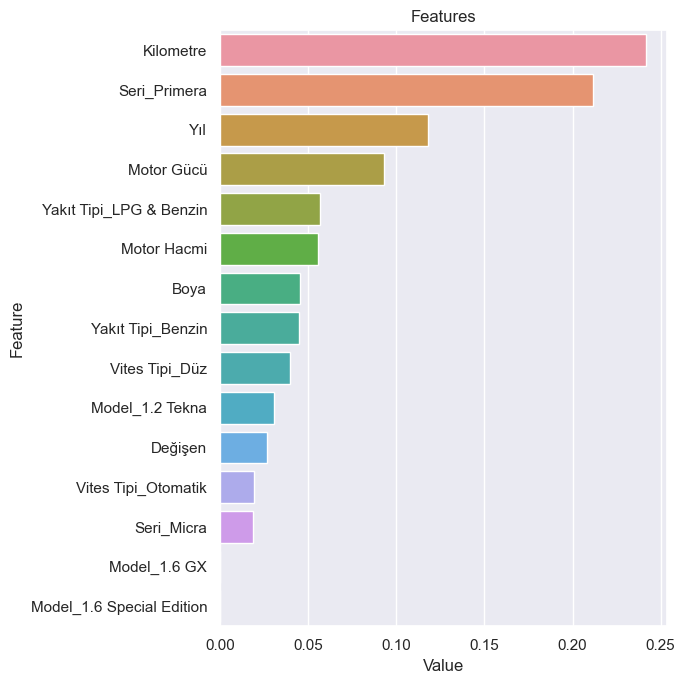

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)